In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest, uniform
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

np.random.seed(42)

In [10]:
class MersenneTwister:
    def __init__(self, seed=5489):
        # Parámetros del MT19937
        self.w, self.n, self.m, self.r = 32, 624, 397, 31
        self.a = 0x9908B0DF
        self.u, self.d = 11, 0xFFFFFFFF
        self.s, self.b = 7, 0x9D2C5680
        self.t, self.c = 15, 0xEFC60000
        self.l = 18
        self.f = 1812433253
        
        # Estado interno
        self.MT = [0] * self.n
        self.index = self.n + 1
        self.lower_mask = (1 << self.r) - 1
        self.upper_mask = (~self.lower_mask) & 0xFFFFFFFF
        
        # Inicializar con semilla
        self.seed_mt(seed)
    
    def seed_mt(self, seed):
        """Inicializa el generador con una semilla"""
        self.index = self.n
        self.MT[0] = seed & 0xFFFFFFFF
        for i in range(1, self.n):
            self.MT[i] = (self.f * (self.MT[i-1] ^ (self.MT[i-1] >> (self.w-2))) + i) & 0xFFFFFFFF
    
    def twist(self):
        """Genera los siguientes n valores del estado"""
        for i in range(self.n):
            x = (self.MT[i] & self.upper_mask) + (self.MT[(i+1) % self.n] & self.lower_mask)
            xA = x >> 1
            if x % 2 != 0:
                xA ^= self.a
            self.MT[i] = self.MT[(i + self.m) % self.n] ^ xA
        self.index = 0
    
    def extract_number(self):
        """Extrae un número aleatorio del estado"""
        if self.index >= self.n:
            self.twist()
        
        y = self.MT[self.index]
        y ^= (y >> self.u) & self.d
        y ^= (y << self.s) & self.b
        y ^= (y << self.t) & self.c
        y ^= y >> self.l
        
        self.index += 1
        return y & 0xFFFFFFFF
    
    def random(self):
        """Genera un número aleatorio en [0, 1)"""
        return self.extract_number() / (2**32)
    
    def generate_uniform(self, n):
        """Genera una muestra uniforme de tamaño n"""
        return np.array([self.random() for _ in range(n)])

In [11]:
mt = MersenneTwister(seed=42)
N = 100000  # Tamaño de muestra
sample_uniform_mt = mt.generate_uniform(N)

print("=" * 60)
print("MERSENNE TWISTER MT19937")
print("=" * 60)
print(f"Tamaño de muestra: {N:,}")
print(f"Semilla: 42")

# Estadísticos descriptivos
print("\nESTADÍSTICOS DESCRIPTIVOS - Mersenne Twister:")
print("-" * 60)
print(f"Media: {np.mean(sample_uniform_mt):.6f} (teórico: 0.5)")
print(f"Varianza: {np.var(sample_uniform_mt):.6f} (teórico: {1/12:.6f})")
print(f"Desviación estándar: {np.std(sample_uniform_mt):.6f} (teórico: {np.sqrt(1/12):.6f})")
print(f"Mínimo: {np.min(sample_uniform_mt):.6f}")
print(f"Máximo: {np.max(sample_uniform_mt):.6f}")
print(f"Mediana: {np.median(sample_uniform_mt):.6f}")

# Prueba de Kolmogorov-Smirnov
ks_stat_mt, p_value_mt = kstest(sample_uniform_mt, 'uniform')
print(f"\nPRUEBA DE KOLMOGOROV-SMIRNOV:")
print(f"Estadístico KS: {ks_stat_mt:.6f}")
print(f"P-valor: {p_value_mt:.6f}")
print(f"Resultado: {'RECHAZA H0' if p_value_mt < 0.05 else 'NO RECHAZA H0'} (α=0.05)")
print(f"Interpretación: La muestra {'NO' if p_value_mt < 0.05 else 'SÍ'} sigue una distribución uniforme")

MERSENNE TWISTER MT19937
Tamaño de muestra: 100,000
Semilla: 42

ESTADÍSTICOS DESCRIPTIVOS - Mersenne Twister:
------------------------------------------------------------
Media: 0.499694 (teórico: 0.5)
Varianza: 0.083087 (teórico: 0.083333)
Desviación estándar: 0.288248 (teórico: 0.288675)
Mínimo: 0.000006
Máximo: 0.999974
Mediana: 0.499989

PRUEBA DE KOLMOGOROV-SMIRNOV:
Estadístico KS: 0.001931
P-valor: 0.849062
Resultado: NO RECHAZA H0 (α=0.05)
Interpretación: La muestra SÍ sigue una distribución uniforme


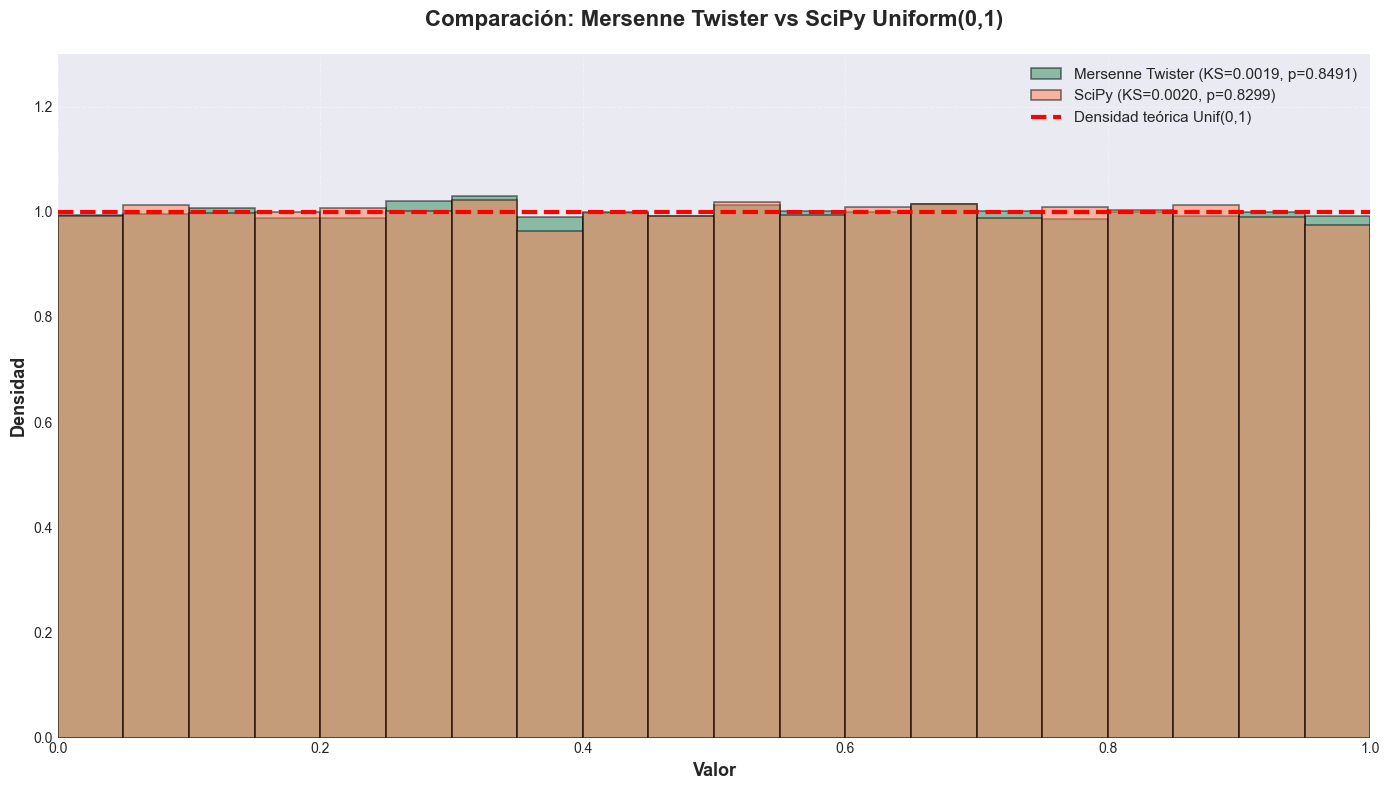

In [12]:
np.random.seed(42)
sample_scipy = np.random.uniform(0, 1, N)

ks_stat_mt, p_value_mt = kstest(sample_uniform_mt, 'uniform')
ks_stat_scipy, p_value_scipy = kstest(sample_scipy, 'uniform')

# Crear figura
fig, ax = plt.subplots(figsize=(14, 8))

# Histogramas superpuestos
ax.hist(sample_uniform_mt, bins=20, density=True, alpha=0.5, 
        color='seagreen', edgecolor='black', linewidth=1.2,
        label=f'Mersenne Twister (KS={ks_stat_mt:.4f}, p={p_value_mt:.4f})')

ax.hist(sample_scipy, bins=20, density=True, alpha=0.5, 
        color='coral', edgecolor='black', linewidth=1.2,
        label=f'SciPy (KS={ks_stat_scipy:.4f}, p={p_value_scipy:.4f})')

# Línea de densidad teórica
ax.axhline(y=1, color='red', linestyle='--', linewidth=3, 
           label='Densidad teórica Unif(0,1)', zorder=10)

ax.set_xlabel('Valor', fontsize=13, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=13, fontweight='bold')
ax.set_title('Comparación: Mersenne Twister vs SciPy Uniform(0,1)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.3])

plt.tight_layout()
plt.show()